In [139]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

In [140]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


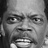

In [141]:
# loading a sample image
sample_image = Image.open("/content/gdrive/My Drive/Train_Relabeled_Cleaned/angry/10.jpg")
sample_image

In [142]:
np.array(sample_image).shape


(48, 48)

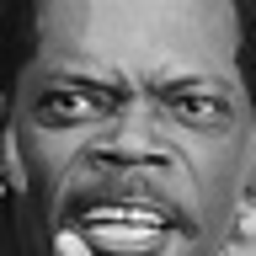

In [143]:
sample_image = sample_image.resize([256,256])
sample_image

In [144]:
np.array(sample_image).shape


(256, 256)

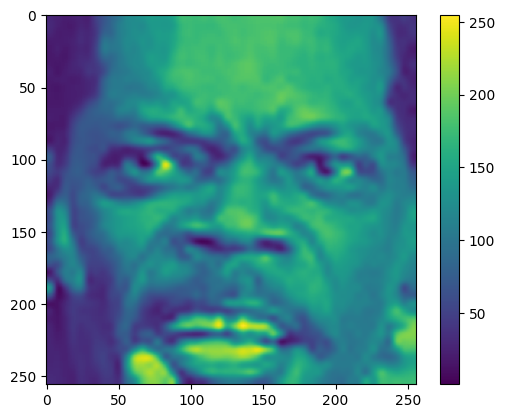

In [145]:
plt.imshow(np.array(sample_image))
plt.colorbar()

# Load Data and Extract only Face


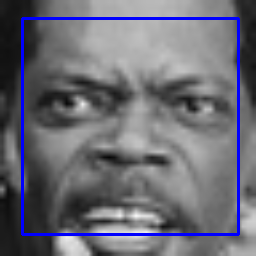

In [146]:
from google.colab.patches import cv2_imshow
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('/content/gdrive/My Drive/Train_Relabeled_Cleaned/angry/10.jpg')
img = cv2.resize(img, dsize=(256,256))
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cropped_img= img[x:x+w, y:y+h]
    cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
    # Display the output
cv2_imshow(img)


In [147]:
cropped_img.shape

(256, 256, 3)

In [148]:
cropped_img = cropped_img.sum(axis=2)

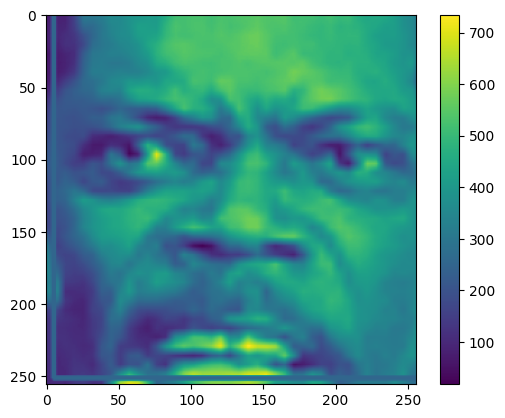

In [149]:
plt.imshow(cropped_img)
plt.colorbar()

# Load Data and Extract Only Face

In [150]:
import cv2

In [151]:
def load_extract_normalize(image_path, normalized=True):
    # Read the input image and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(256,256))
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # crop faces
    for (x, y, w, h) in faces:
        cropped_img= img[x:x+w, y:y+h].astype('float32')
        cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
        cropped_img = cropped_img.sum(axis=2)

    if normalized:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32) / 255.0
        else:
          return np.array(img).astype(np.float32) / 255.0
    else:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32)
        else:
          return np.array(img).astype(np.float32)

In [152]:
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([200,200])
    # if len(np.array(image).shape) == 3:
    #     image = image.sum(axis=2)
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

In [153]:
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Train_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [154]:
for i,img in enumerate(x_data):
  if len(img.shape) == 3:
    x_data[i] = img.sum(axis=2)

(22036, 200, 200, 1) (22036, 7)
(5510, 200, 200, 1) (5510, 7)


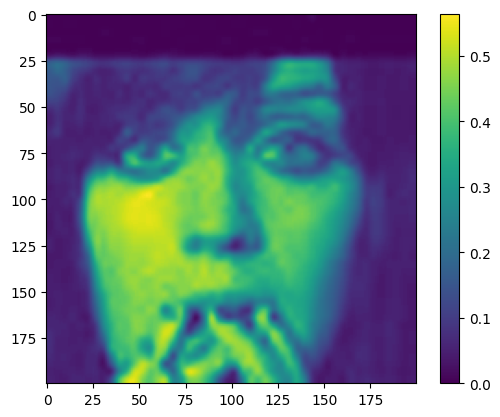

In [155]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 200, 200, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

In [156]:
# train and fit a resnet50 model
resnet50_model = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=7)
# model summary
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [157]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [158]:
# compile the model
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [159]:
n_epoch = 30
# train the model
resnet50_model.fit(x_train, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val, y_val),
                callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 78s 62ms/step - loss: 1.8170 - categorical_accuracy: 0.2654 - val_loss: 2.3220 - val_categorical_accuracy: 0.1748
Epoch 2/30
689/689 [==============================] - 40s 58ms/step - loss: 1.6551 - categorical_accuracy: 0.3545 - val_loss: 1.8361 - val_categorical_accuracy: 0.3238
Epoch 3/30
689/689 [==============================] - 40s 58ms/step - loss: 1.4865 - categorical_accuracy: 0.4304 - val_loss: 1.8829 - val_categorical_accuracy: 0.3775
Epoch 4/30
689/689 [==============================] - 40s 58ms/step - loss: 1.3258 - categorical_accuracy: 0.4934 - val_loss: 1.5132 - val_categorical_accuracy: 0.4200
Epoch 5/30
689/689 [==============================] - 40s 58ms/step - loss: 1.1948 - categorical_accuracy: 0.5481 - val_loss: 1.4904 - val_categorical_accuracy: 0.4630
Epoch 6/30
689/689 [==============================] - 40s 58ms/step - loss: 1.0688 - categorical_accuracy: 0.6002 - val_loss: 1.5556 - val_categorical_accuracy:

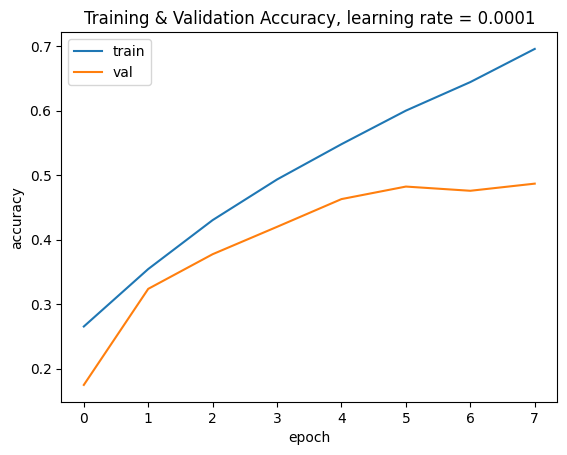

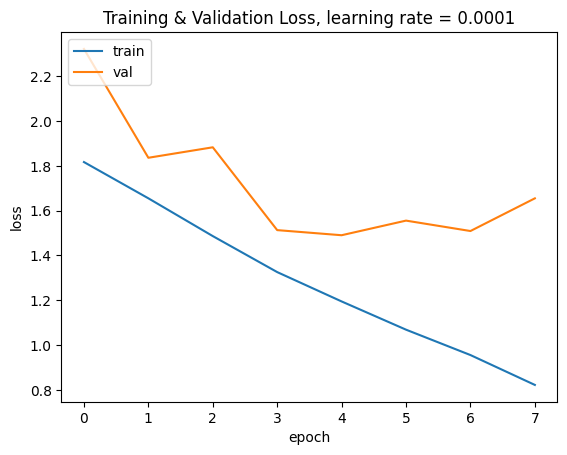

In [160]:
# save the model
resnet50_model.save('resnet50_model.h5')

# plot the accuracy and loss
plt.plot(resnet50_model.history.history['categorical_accuracy'])
plt.plot(resnet50_model.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model.history.history['loss'])
plt.plot(resnet50_model.history.history['val_loss'])
plt.title('Training & Validation Loss, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [161]:
resnet50_model.save('/content/gdrive/My Drive/IDS705/resnet50_model_v2')

Seems with little overfitting issue. Try batch normalisation and drop Out

## Batch Normalisation and Drop Out

In [177]:
# batch normalization and dropout
# train and fit a resnet50 model
resnet50_model_bn = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=7)
# model summary
resnet50_model_bn.summary()

# add batch normalization and dropout
for layer in resnet50_model_bn.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [178]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss  
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor


In [179]:
n_epoch = 30
# train the model
resnet50_model_bn.fit(x_train, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val, y_val),
                callbacks=[callback])


Epoch 1/30
689/689 [==============================] - 80s 62ms/step - loss: 1.7970 - categorical_accuracy: 0.2781 - val_loss: 2.6453 - val_categorical_accuracy: 0.2407
Epoch 2/30
689/689 [==============================] - 41s 59ms/step - loss: 1.6171 - categorical_accuracy: 0.3732 - val_loss: 1.6668 - val_categorical_accuracy: 0.3924
Epoch 3/30
689/689 [==============================] - 40s 58ms/step - loss: 1.4500 - categorical_accuracy: 0.4494 - val_loss: 1.9712 - val_categorical_accuracy: 0.3207
Epoch 4/30
689/689 [==============================] - 40s 58ms/step - loss: 1.2908 - categorical_accuracy: 0.5132 - val_loss: 1.5553 - val_categorical_accuracy: 0.4145
Epoch 5/30
689/689 [==============================] - 40s 58ms/step - loss: 1.1660 - categorical_accuracy: 0.5604 - val_loss: 1.7432 - val_categorical_accuracy: 0.3653
Epoch 6/30
689/689 [==============================] - 40s 58ms/step - loss: 1.0384 - categorical_accuracy: 0.6120 - val_loss: 1.4962 - val_categorical_accuracy:

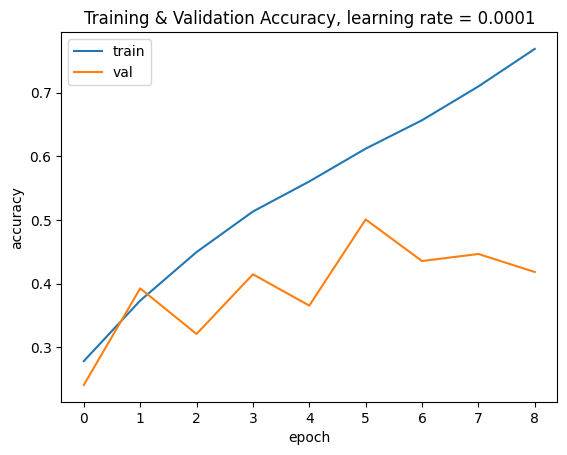

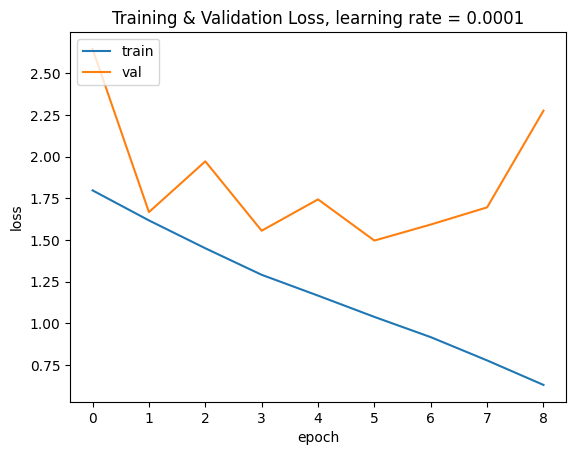

In [181]:
# plot the accuracy and loss
plt.plot(resnet50_model_bn.history.history['categorical_accuracy'])
plt.plot(resnet50_model_bn.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_bn.history.history['loss'])
plt.plot(resnet50_model_bn.history.history['val_loss'])
plt.title('Training & Validation Loss, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [182]:
# save the model
resnet50_model_bn.save_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_v2')

# Test the Model with No Overfitting Control

In [162]:
x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

In [163]:
# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 200, 200, 1)
y_test = np.array(y_test)
y_test = np.eye(len(emo_types))[y_test]

print(x_test.shape, y_test.shape)

# plt.imshow(x_test[0,:,:,0])
# plt.colorbar()

(6488, 200, 200, 1) (6488, 7)


In [164]:
# Evaluate the model
loss, acc = resnet50_model.evaluate(x_test, y_test, verbose=2)
print("Resnet50 model with no overfitting control, accuracy: {:5.2f}%".format(100 * acc))
y_pred = resnet50_model.predict(x_test, verbose=2)

203/203 - 3s - loss: 1.7439 - categorical_accuracy: 0.4735 - 3s/epoch - 13ms/step
Resnet50 model with no overfitting control, accuracy: 47.35%
203/203 - 3s - 3s/epoch - 16ms/step


In [165]:
y_pred = np.argmax(y_pred,axis = 1)
y_pred

array([4, 1, 0, ..., 3, 3, 6])

In [166]:
y_test = np.argmax(y_test,axis = 1)
y_test

array([0, 0, 0, ..., 6, 6, 6])

In [167]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.49      0.16      0.24       888
           1       0.11      0.48      0.18        83
           2       0.67      0.03      0.06       916
           3       0.72      0.72      0.72      1752
           4       0.41      0.57      0.48      1181
           5       0.32      0.60      0.42      1088
           6       0.69      0.47      0.56       580

    accuracy                           0.47      6488
   macro avg       0.49      0.43      0.38      6488
weighted avg       0.55      0.47      0.45      6488



In [168]:
# the f1 socre of the weighted average
f1_score(y_test, y_pred, average='weighted')

0.44673182737749195

In [176]:
f1_score(y_test, y_pred, average=None)[6]

0.5611510791366907

In [169]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.15990991, 0.48192771, 0.03275109, 0.72203196, 0.56646909,
       0.60018382, 0.47068966])

# Test the Model with Overfitting Control

In [183]:
x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

In [184]:
# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 200, 200, 1)
y_test = np.array(y_test)
y_test = np.eye(len(emo_types))[y_test]

print(x_test.shape, y_test.shape)

# plt.imshow(x_test[0,:,:,0])
# plt.colorbar()

(6488, 200, 200, 1) (6488, 7)


In [185]:
# Evaluate the model
loss, acc = resnet50_model_bn.evaluate(x_test, y_test, verbose=2)
print("Resnet50 model with overfitting control, accuracy: {:5.2f}%".format(100 * acc))

203/203 - 3s - loss: 2.3031 - categorical_accuracy: 0.4105 - 3s/epoch - 13ms/step
Resnet50 model with overfitting control, accuracy: 41.05%


In [186]:
y_pred = resnet50_model_bn.predict(x_test, verbose=2)
y_pred = np.argmax(y_pred,axis = 1)
y_pred

203/203 - 3s - 3s/epoch - 16ms/step


array([4, 1, 2, ..., 6, 2, 6])

In [187]:
y_test = np.argmax(y_test,axis = 1)
y_test

array([0, 0, 0, ..., 6, 6, 6])

In [188]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
print(classification_report(y_test,y_pred, zero_division=1))


              precision    recall  f1-score   support

           0       0.50      0.02      0.05       888
           1       0.05      0.72      0.09        83
           2       0.28      0.46      0.34       916
           3       0.88      0.59      0.71      1752
           4       0.43      0.56      0.48      1181
           5       0.52      0.05      0.09      1088
           6       0.48      0.72      0.57       580

    accuracy                           0.41      6488
   macro avg       0.45      0.45      0.33      6488
weighted avg       0.55      0.41      0.40      6488



In [199]:
# the f1 socre of the weighted average
f1_score(y_test, y_pred, average='weighted')

0.400300707544621

In [198]:
f1_score(y_test, y_pred, average=None)[0]

0.04516129032258064

In [191]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.02364865, 0.72289157, 0.45524017, 0.58732877, 0.56392887,
       0.046875  , 0.72241379])